#### About the dataset

Insurance fraud is a huge problem in the industry. It's difficult to identify fraud claims. Machine Learning is in a unique position to help the Auto Insurance industry with this problem.

In this project, you are provided a dataset which has the details of the insurance policy along with the customer details. It also has the details of the accident on the basis of which the claims have been made. 

In this example, you will be working with some auto insurance data to demonstrate how you can create a predictive model that predicts if an insurance claim is fraudulent or not. 

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,RandomizedSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve,roc_auc_score,plot_roc_curve
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import pickle
import warnings
warnings.filterwarnings('ignore')

#### Loading the dataset

In [87]:
df = pd.read_csv("Automobile_insurance_fraud.csv")
df.head(5)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,06-06-2014,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [3]:
df['fraud_reported'].value_counts()

N    753
Y    247
Name: fraud_reported, dtype: int64

#### The above problem is a classification problem

#### Checking for null values

In [4]:
df.isnull().sum()

months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital-gains                     0
capital-loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted             0
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0
property_damage             

#### c_39 is full of NaN values so its better to drop while cleaning the data

In [5]:
df['police_report_available'].value_counts()

?      343
NO     343
YES    314
Name: police_report_available, dtype: int64

#### The frequency of No is more as compared to yes, so lets replace ? with No

In [88]:
df['police_report_available']=df['police_report_available'].replace(to_replace="?",value="NO")

In [89]:
df['police_report_available'].value_counts()

NO     686
YES    314
Name: police_report_available, dtype: int64

#### Before analysing the relationship lets convert object datatypes to numerical

In [90]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
for column in df:
    df[column] = label_enc.fit_transform(df[column])
df.head(5)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,299,29,480,532,2,1,1,732,1,486,...,1,563,258,512,545,10,1,9,1,0
1,212,23,257,821,1,1,2,396,5,519,...,0,44,46,45,38,8,12,12,1,0
2,123,10,672,186,2,0,2,740,5,6,...,0,143,337,104,116,4,30,12,0,0
3,239,22,140,766,0,1,2,743,6,812,...,0,451,245,249,521,3,34,19,1,0
4,212,25,286,181,0,2,1,902,6,850,...,0,81,70,36,66,0,31,14,0,0


In [37]:
df.shape

(1000, 40)

### EDA

#### Plotting the relationship between target variable and feature variable

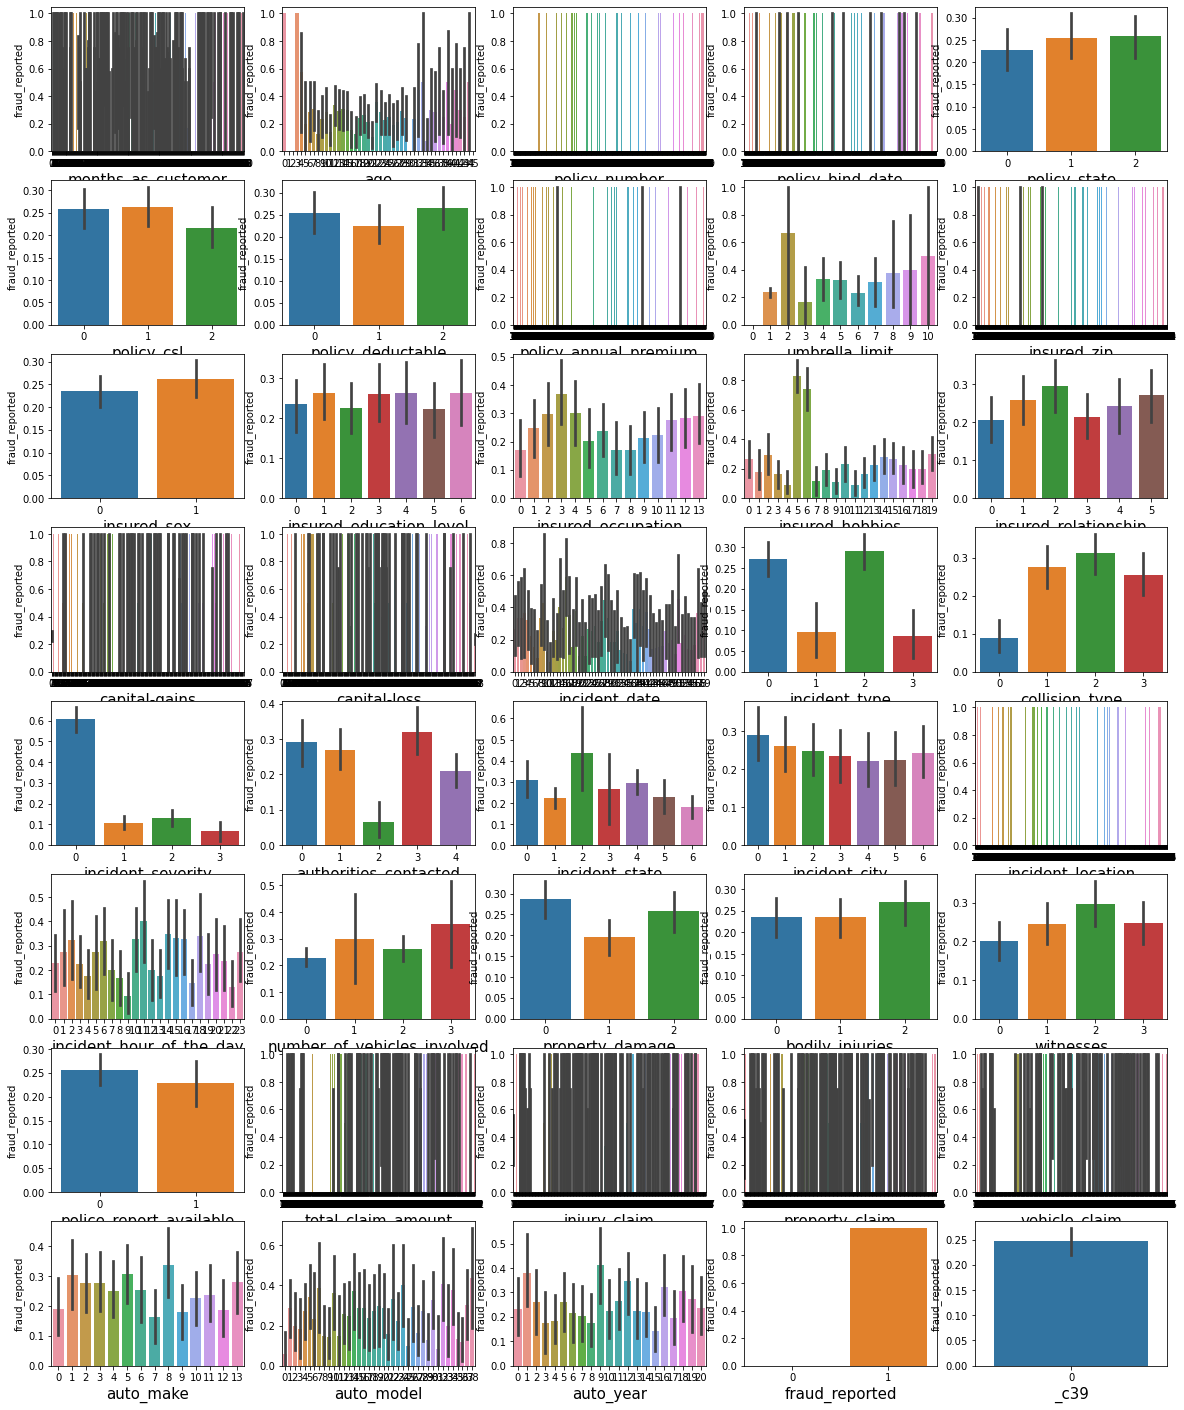

In [38]:
plt.figure(figsize=(20,25))
gr = 1
for column in df:
    if gr<=40:
        ax = plt.subplot(8,5,gr)
        sns.barplot(x = df[column],y=df['fraud_reported'],data=df)
        plt.xlabel(column,fontsize=15)
    gr+=1
plt.show()

#### From the graph its clear that injury_claim, property_claim, vehicle_claim etc doesn't have a major role in the fraud detection

#### Checking the correlation

In [39]:
df.corr()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
months_as_customer,1.000000,0.911296,0.059023,0.053206,-0.000783,-0.026295,0.016873,0.014294,0.017145,0.015904,...,-0.020217,0.055934,0.064041,0.029788,0.052742,0.044443,0.001095,0.002020,0.017095,NaN
age,0.911296,1.000000,0.061380,0.056538,-0.014533,-0.015185,0.020561,0.017822,0.021924,0.013517,...,-0.020441,0.071265,0.075124,0.060450,0.059784,0.030410,0.017343,0.001354,0.012143,NaN
policy_number,0.059023,0.061380,1.000000,0.045938,0.073149,0.038834,-0.015075,0.018033,0.013341,-0.000690,...,0.032356,-0.009532,-0.012413,-0.003358,-0.014299,0.024663,0.064259,0.000465,-0.030222,NaN
policy_bind_date,0.053206,0.056538,0.045938,1.000000,0.015289,0.008486,-0.016906,-0.032003,-0.024888,-0.032670,...,-0.011563,0.009868,0.026021,0.016972,0.009028,-0.025955,0.000306,0.035067,0.060642,NaN
policy_state,-0.000783,-0.014533,0.073149,0.015289,1.000000,0.001027,0.008213,0.014751,-0.031793,0.025074,...,0.069017,-0.015990,-0.042685,0.009282,-0.007492,0.017124,-0.025253,0.002114,0.029432,NaN
policy_csl,-0.026295,-0.015185,0.038834,0.008486,0.001027,1.000000,0.001986,0.017161,0.022779,0.006474,...,-0.001645,-0.043541,-0.076419,-0.041428,-0.027320,-0.004701,0.047885,-0.033082,-0.037190,NaN
policy_deductable,0.016873,0.020561,-0.015075,-0.016906,0.008213,0.001986,1.000000,0.003182,0.009402,-0.004227,...,0.040129,0.020877,0.028482,0.058976,0.004261,-0.030775,-0.003892,0.024921,0.007620,NaN
policy_annual_premium,0.014294,0.017822,0.018033,-0.032003,0.014751,0.017161,0.003182,1.000000,-0.003712,0.043082,...,0.016026,-0.001025,-0.021839,-0.006593,0.009413,0.007216,-0.030185,-0.031015,-0.015261,NaN
umbrella_limit,0.017145,0.021924,0.013341,-0.024888,-0.031793,0.022779,0.009402,-0.003712,1.000000,0.010062,...,-0.042278,-0.036495,-0.048003,-0.018668,-0.031991,-0.007169,0.042421,0.010528,0.057719,NaN
insured_zip,0.015904,0.013517,-0.000690,-0.032670,0.025074,0.006474,-0.004227,0.043082,0.010062,1.000000,...,-0.009889,-0.005345,-0.005417,-0.014892,-0.017019,-0.028966,0.029470,-0.027803,0.061767,NaN


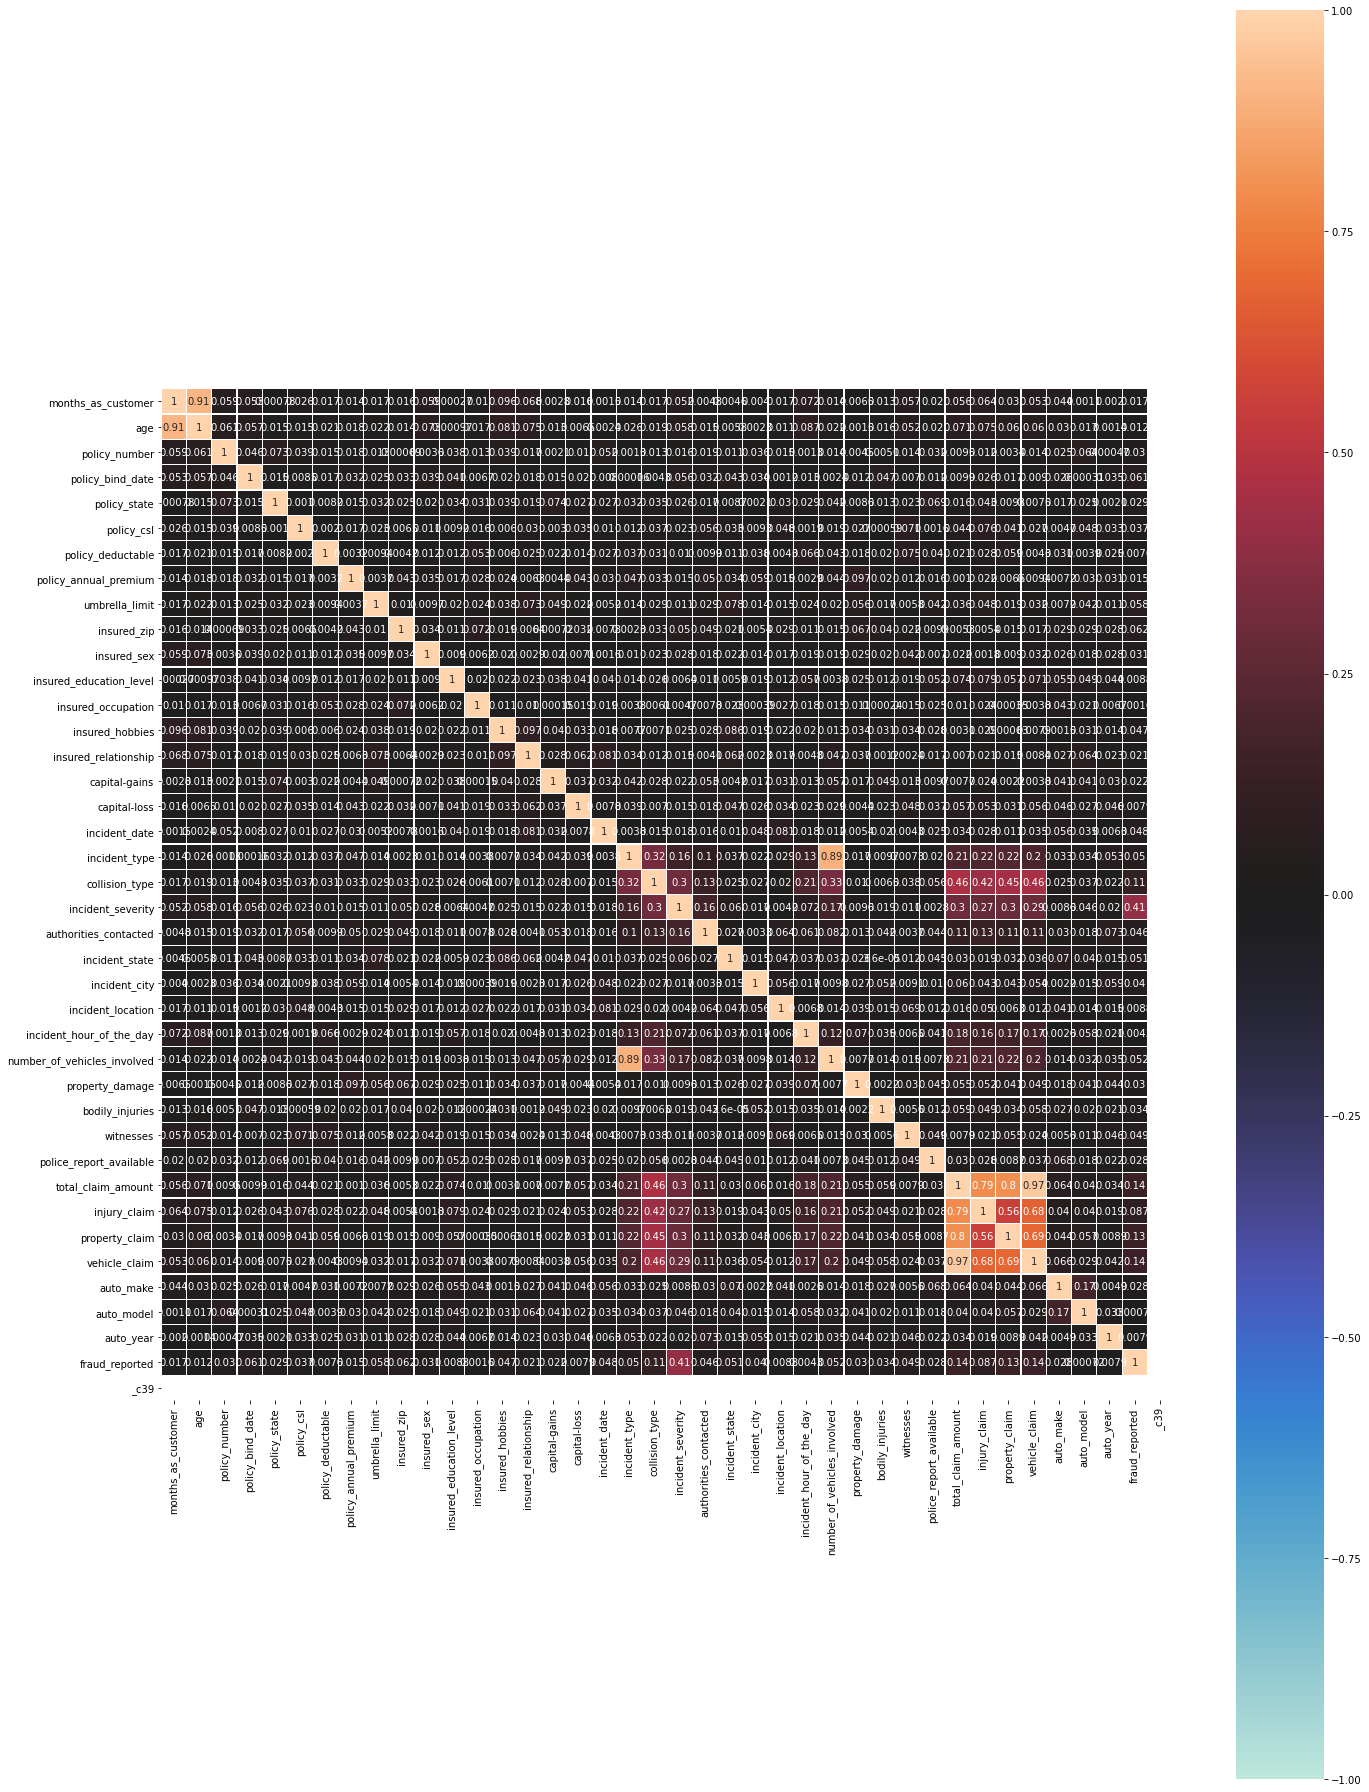

In [40]:
df_corr = df.corr().abs()
plt.figure(figsize=(20,25))
sns.heatmap(df_corr,vmin=-1,vmax=1,annot=True,square = True,center=0,fmt='.2g',linewidth=.2)
plt.tight_layout()

#### From the visualization its clear that multicollinearity exists
#### incident_severity have the maximum correlation with fraud_reported followed by total_claim_amount,property_claim and vehicle_claim

#### Statistical Inference about the dataset

In [42]:
df.describe()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0
mean,182.500000,19.900000,358.300000,394.700000,0.800000,0.700000,1.100000,644.200000,2.800000,569.000000,...,0.300000,297.200000,246.400000,213.400000,283.700000,6.700000,15.500000,12.900000,0.400000,0.0
std,77.933376,5.704774,204.523864,303.877552,0.918937,0.674949,0.737865,177.937442,2.347576,282.963288,...,0.483046,215.744087,180.404607,159.802795,215.445817,4.295993,13.810222,5.820462,0.516398,0.0
min,24.000000,10.000000,2.000000,60.000000,0.000000,0.000000,0.000000,315.000000,1.000000,6.000000,...,0.000000,44.000000,46.000000,36.000000,38.000000,0.000000,1.000000,1.000000,0.000000,0.0
25%,132.750000,15.750000,264.250000,144.250000,0.000000,0.000000,1.000000,592.250000,1.000000,494.250000,...,0.000000,126.500000,97.250000,90.500000,113.750000,3.250000,3.500000,9.750000,0.000000,0.0
50%,205.000000,21.000000,349.500000,285.500000,0.500000,1.000000,1.000000,686.500000,1.000000,695.000000,...,0.000000,232.000000,248.000000,193.500000,197.500000,8.500000,10.500000,13.000000,0.000000,0.0
75%,232.250000,23.000000,467.000000,707.500000,1.750000,1.000000,1.750000,742.250000,5.000000,738.750000,...,0.750000,460.000000,317.250000,295.500000,518.750000,10.000000,29.750000,17.000000,1.000000,0.0
max,299.000000,29.000000,672.000000,821.000000,2.000000,2.000000,2.000000,902.000000,6.000000,850.000000,...,1.000000,642.000000,637.000000,512.000000,545.000000,12.000000,34.000000,20.000000,1.000000,0.0


#### Checking for outliers

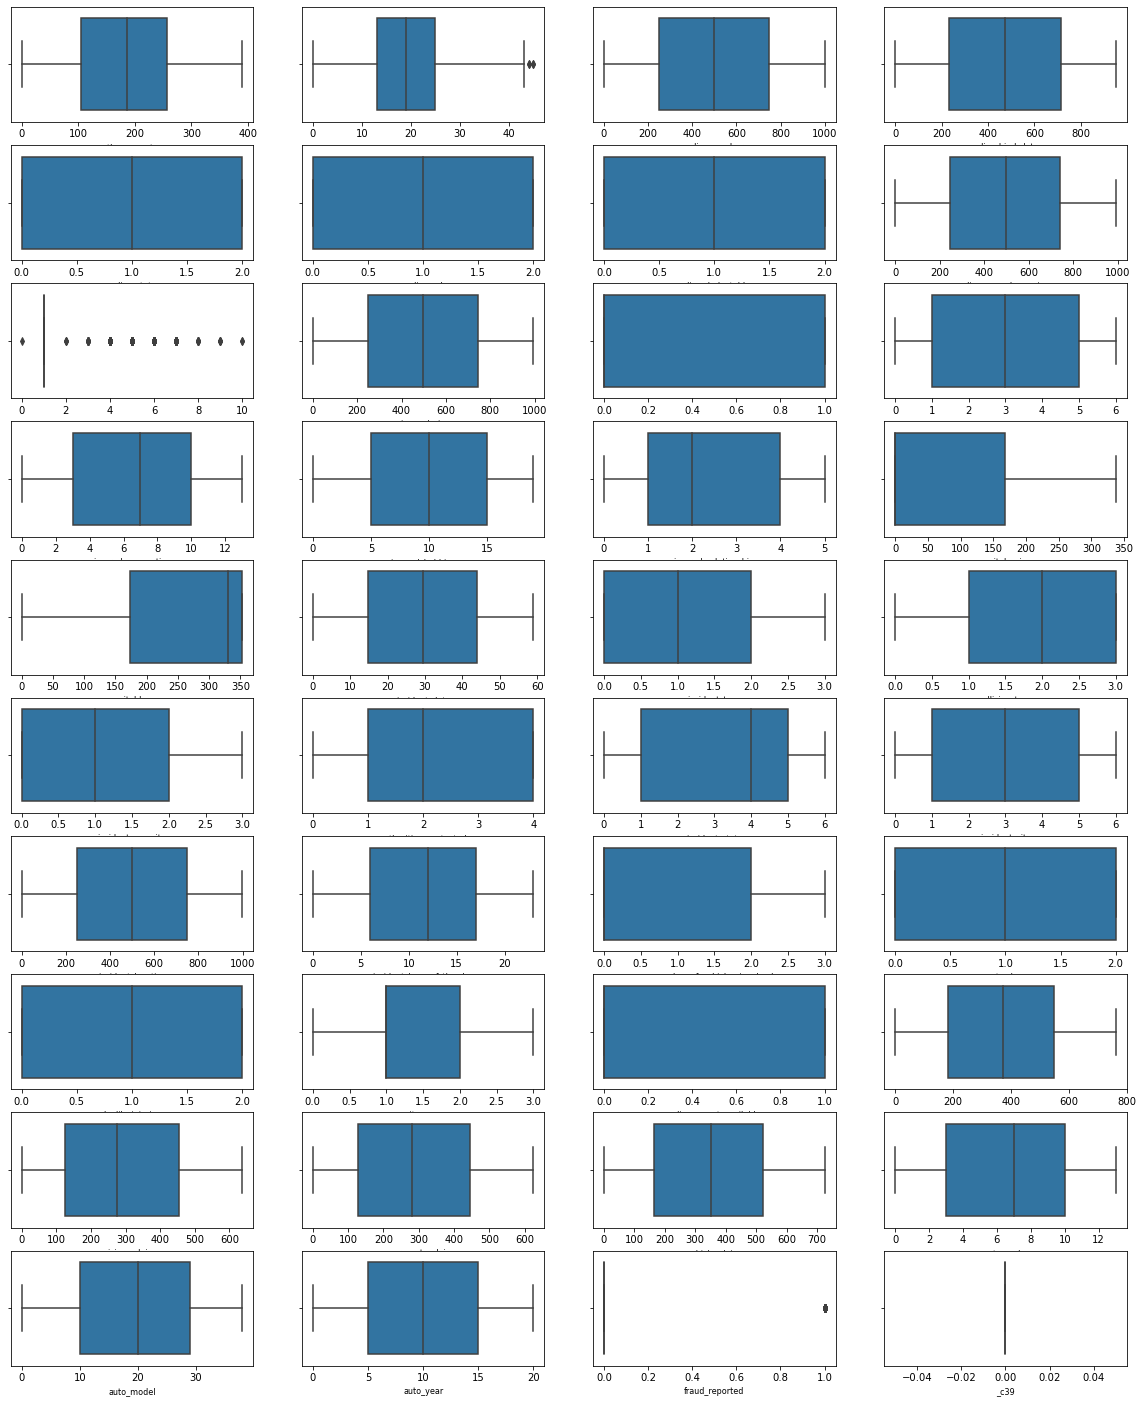

In [44]:
plt.figure(figsize=(20,25))
gr = 1
for column in df:
    if gr<=40:
        ax = plt.subplot(10,4,gr)
        sns.boxplot(df[column],orient='v')
        plt.xlabel(column,fontsize=8)
    gr+=1
plt.show()

#### Outlier exists in the column umbrella_limit

#### Checking skewness

In [45]:
df.skew()

months_as_customer             0.092231
age                            0.478988
policy_number                  0.000000
policy_bind_date               0.005194
policy_state                  -0.026177
policy_csl                     0.088928
policy_deductable              0.063505
policy_annual_premium         -0.004022
umbrella_limit                 1.936066
insured_zip                    0.001683
insured_sex                    0.148630
insured_education_level       -0.000148
insured_occupation            -0.058881
insured_hobbies               -0.061563
insured_relationship           0.077488
capital-gains                  0.894996
capital-loss                  -0.810352
incident_date                  0.004756
incident_type                  0.101507
collision_type                -0.193345
incident_severity              0.279016
authorities_contacted         -0.121744
incident_state                -0.148865
incident_city                  0.049531
incident_location              0.000000


#### Skewness exists in umbrella_limit and target variable(which is due to class imbalance)

#### Visualizing the statistical distribution

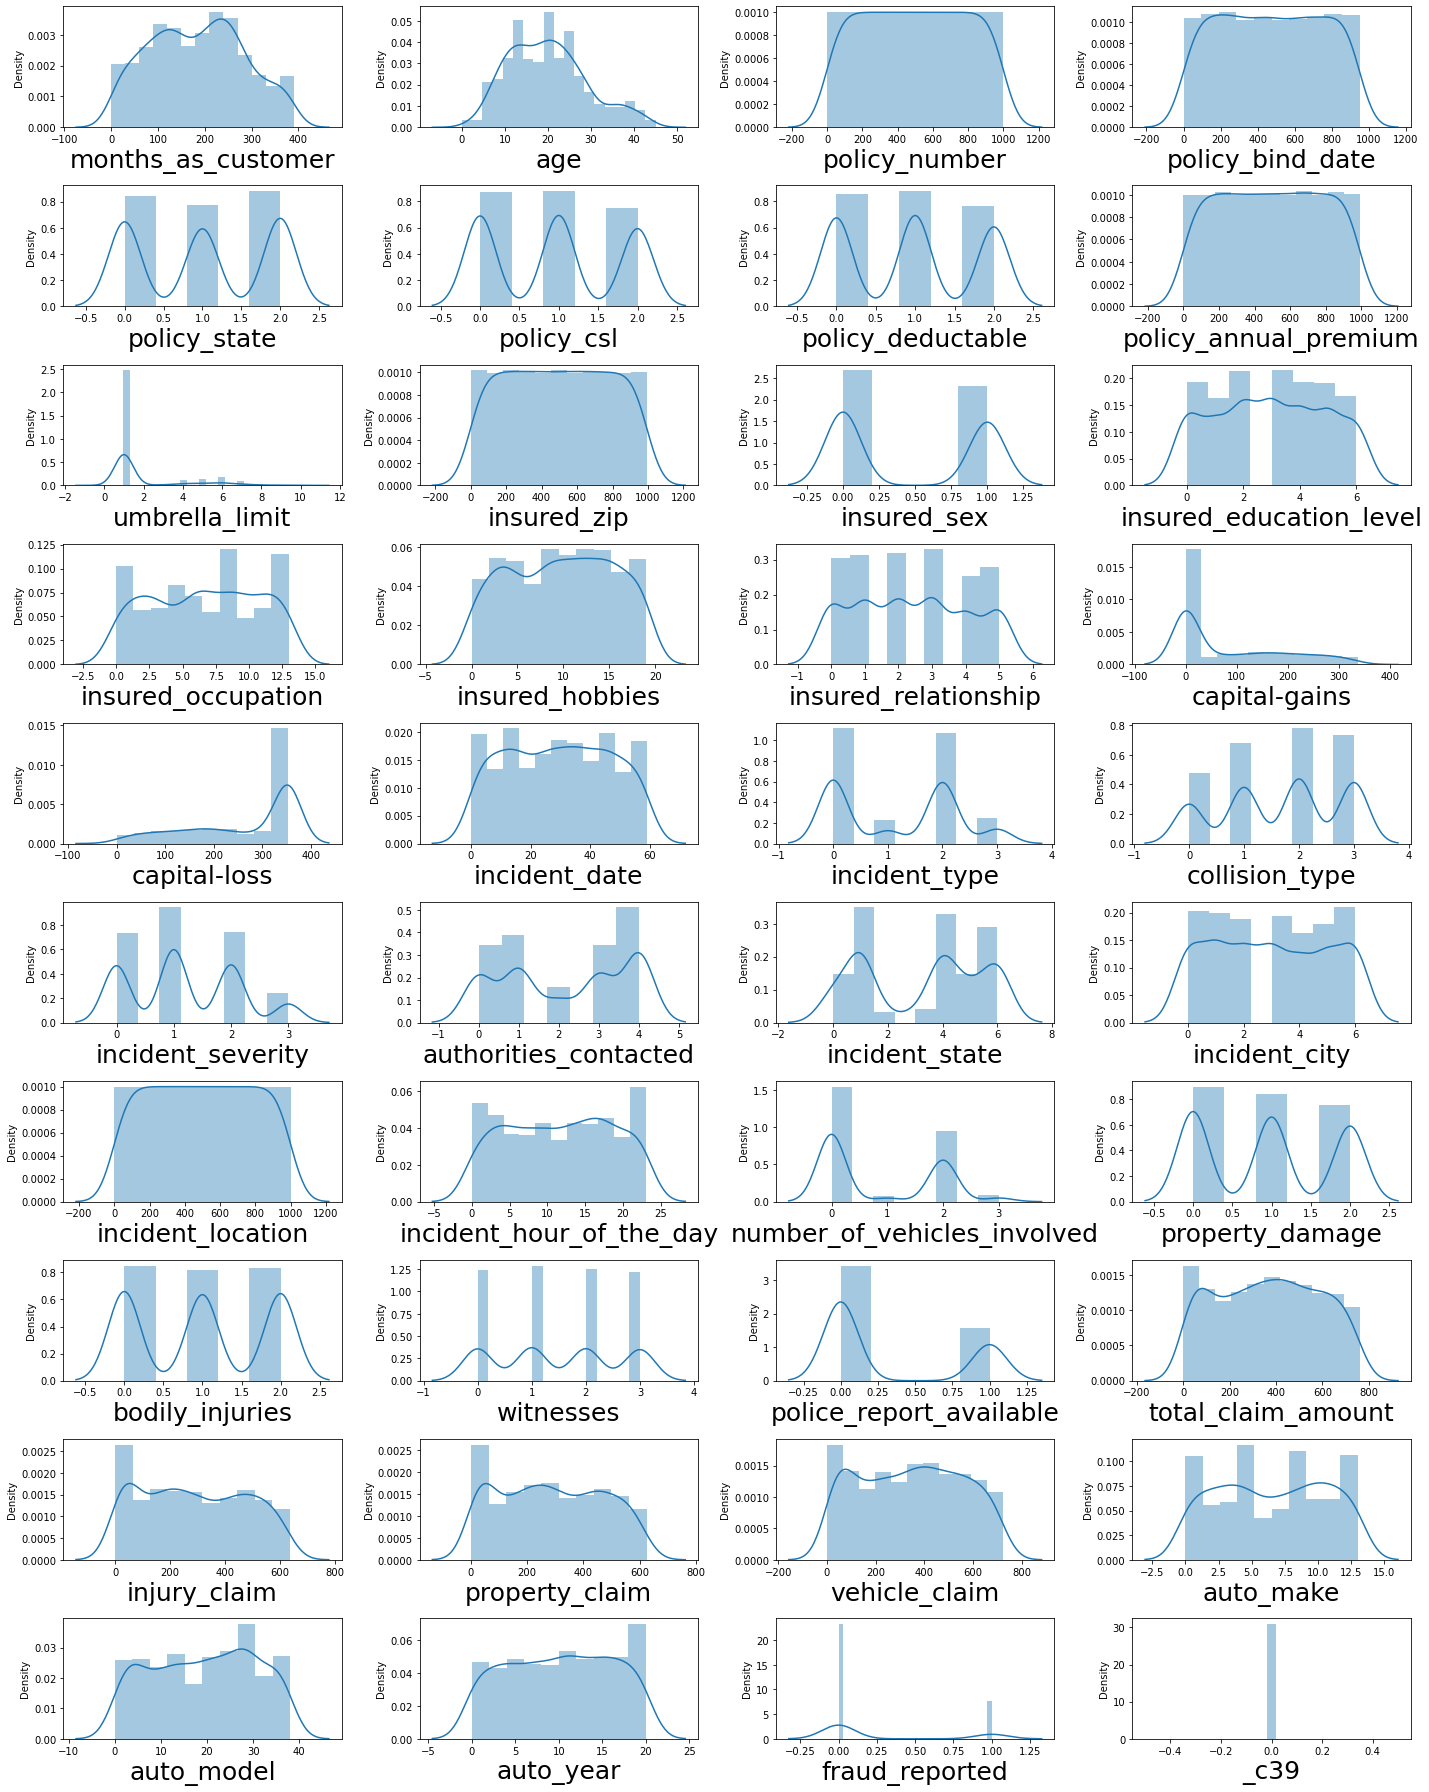

In [46]:
plt.figure(figsize=(20,25),facecolor="white")
plotnumber=1
for column in df:
    if plotnumber<=40:
        ax=plt.subplot(10,4,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=25)
    plotnumber+=1
plt.tight_layout()

### Data Cleaning

#### Dropping umbrella_limit and _c39 because umbrella_limit have outliers and is skewed and has negligible correlation with target variable, _c39 has only 0 as value

In [91]:
df = df.drop(columns=['umbrella_limit','_c39'],axis=1)
df.head(3)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,insured_zip,insured_sex,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,299,29,480,532,2,1,1,732,486,1,...,2,1,563,258,512,545,10,1,9,1
1,212,23,257,821,1,1,2,396,519,1,...,0,0,44,46,45,38,8,12,12,1
2,123,10,672,186,2,0,2,740,6,0,...,3,0,143,337,104,116,4,30,12,0


In [92]:
df['fraud_reported'].value_counts()

0    753
1    247
Name: fraud_reported, dtype: int64

#### Visualizing the class imbalance in target variable fraud_reported

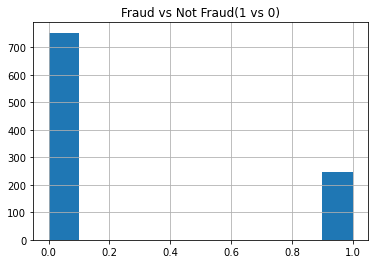

In [49]:
df['fraud_reported'].hist(grid=True)
plt.title("Fraud vs Not Fraud(1 vs 0)")
plt.show()

#### Frauds are much less as compared to non-frauds

#### Since we dropped umbrella_limit the dataset doesn't have any outliers

#### Splitting the dataset into target variable and feature variable

In [93]:
x = df.drop('fraud_reported',axis=1)
y = df['fraud_reported']

#### Removing skewness

In [94]:
from sklearn.preprocessing import power_transform
x_new = power_transform(x,method='yeo-johnson')
x_new

array([[ 1.10818267,  0.99622955,  0.03561288, ...,  0.85911096,
        -1.80834465, -0.10459768],
       [ 0.34219532,  0.42237364, -0.76129808, ...,  0.41861586,
        -0.58622515,  0.36985125],
       [-0.53491143, -1.12118031,  0.63590085, ..., -0.55514878,
         0.94490524,  0.36985125],
       ...,
       [-0.57765348, -0.45989302,  1.29246222, ...,  1.07113608,
         0.04546316, -1.61360454],
       [ 1.74586026,  2.15624561,  0.10103298, ..., -1.44076333,
        -1.30534129, -1.17900402],
       [ 1.73791855,  2.00231434,  0.17533531, ...,  0.41861586,
        -0.58622515,  0.36985125]])

#### Checking skewness

In [95]:
x_new = pd.DataFrame(x_new,columns=x.columns)
x_new.skew()

months_as_customer            -0.212356
age                           -0.027267
policy_number                 -0.288423
policy_bind_date              -0.291937
policy_state                  -0.145377
policy_csl                    -0.100769
policy_deductable             -0.111017
policy_annual_premium         -0.288883
insured_zip                   -0.288646
insured_sex                    0.148630
insured_education_level       -0.188564
insured_occupation            -0.239336
insured_hobbies               -0.247798
insured_relationship          -0.160421
capital-gains                  0.130054
capital-loss                  -0.623731
incident_date                 -0.264053
incident_type                 -0.088766
collision_type                -0.204204
incident_severity             -0.079282
authorities_contacted         -0.227269
incident_state                -0.255777
incident_city                 -0.181772
incident_location             -0.288423
incident_hour_of_the_day      -0.256957


#### Still skewness exists in ploice_report_available

#### Balancing the target variable by upsampling

In [96]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
x_over,y_over = sm.fit_resample(x,y)

In [97]:
y_over.value_counts()

1    753
0    753
Name: fraud_reported, dtype: int64

#### Scaling feature variables

In [98]:
scale = StandardScaler()
X_scaled = scale.fit_transform(x_over)

#### Checking Multicollinearity by variance_inflation_factor

In [99]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_scaled,i) for i in range(x_new.shape[1])]
vif["Features"] = x.columns
vif

,vif,Features
0,6.448011,months_as_customer
1,6.457148,age
2,1.051696,policy_number
3,1.038789,policy_bind_date
4,1.063584,policy_state
5,1.068668,policy_csl
6,1.065402,policy_deductable
7,1.053331,policy_annual_premium
8,1.082086,insured_zip
9,1.054499,insured_sex


#### Removing multicollinearity by PCA

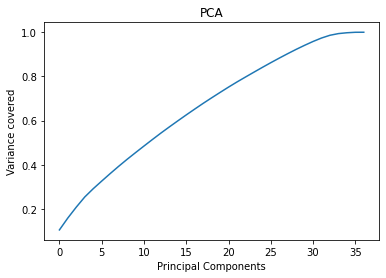

In [100]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_scaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Principal Components")
plt.ylabel("Variance covered")
plt.title("PCA")
plt.show()

In [101]:
pca = PCA(n_components=32)
principal = pca.fit_transform(X_scaled)
principal_x = pd.DataFrame(principal,columns=['PC1','PC2',"PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11",'PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21','PC22',"PC23","PC24","PC25","PC26","PC27","PC28","PC29","PC30",'PC31','PC32'])
principal_x

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32
0,-1.064382,1.077090,-1.291204,2.758313,3.037867,-1.069123,-0.170285,0.622954,0.273025,-1.009353,...,-0.902155,-0.411020,-1.205655,0.812109,-0.483260,-0.550943,1.836020,-0.438603,-1.173644,0.401005
1,4.163587,0.598488,-0.835025,-0.025395,0.173716,-1.600120,-1.069800,-0.349951,0.981291,-0.270633,...,0.581228,-0.597461,0.946956,1.053277,0.936471,1.095687,0.887868,-0.231289,-0.168994,-0.681241
2,1.273312,-1.003402,1.932004,1.140687,-1.583630,1.543772,0.034808,0.891664,-0.766451,-1.704661,...,-0.031759,0.171225,1.571839,0.401890,-2.494515,0.238342,-0.467313,-1.134325,-0.689431,-0.008649
3,0.316865,1.152939,-0.924434,-0.838074,-1.466512,1.759363,-2.474570,-1.061366,2.283686,-0.367706,...,-0.987718,-0.004973,-0.316137,-0.924185,0.039996,0.345731,0.281608,-1.078942,-0.204541,0.141717
4,3.339269,1.869514,-0.252953,-1.103900,-0.591594,2.568331,1.641880,0.462056,-0.313540,-0.459734,...,-0.155628,-0.497484,-1.530732,-1.138595,2.317596,1.023421,-0.018736,0.037082,0.148956,-0.523785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,0.850475,-0.783461,-1.667111,-1.456175,0.257206,0.253203,0.395980,-0.788795,-0.825049,-0.584877,...,1.982486,-1.104814,-1.405461,-0.015457,-1.034448,-0.362644,-0.621408,0.162923,-0.678497,-0.528702
1502,0.176463,1.061524,-0.683907,-2.002599,1.001030,0.440965,1.054953,0.274467,1.010552,-1.019303,...,1.366700,0.175828,-0.234424,-0.381654,0.507587,0.251786,0.195222,0.745854,-0.604396,-0.074637
1503,0.394047,-0.380943,-1.473323,-0.919632,-0.045917,-0.534488,-1.530594,0.903216,0.411575,2.608290,...,0.121311,0.304281,0.435687,0.458808,-1.274538,0.746621,-0.150576,0.192146,-0.339143,-0.316190
1504,-1.649361,-0.037177,-1.051526,-1.008713,-0.714240,-0.065251,-0.951882,0.370311,1.126392,-0.606889,...,-0.784029,0.260962,0.435096,0.180529,-0.231416,-0.172625,0.591207,0.572883,0.200251,-0.500171


#### Finding the best random state

In [102]:
max_accuracy = 0
max_rs = 0
for i in range(1,500):
    x_train,x_test,y_train,y_test = train_test_split(principal_x,y_over,test_size=0.25,random_state = i)
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    y_pred = LR.predict(x_test)
    accu_score = accuracy_score(y_test,y_pred)
    if accu_score>max_accuracy:
        max_accuracy = accu_score
        max_rs = i
print("Maximum accuracy is",max_accuracy,"when",max_rs,"is the random state")

Maximum accuracy is 0.8567639257294429 when 80 is the random state


#### Splitting the dataset into train and test

In [103]:
x_train,x_test,y_train,y_test = train_test_split(principal_x,y_over,test_size=0.25,random_state = 80)

### Model Training

#### Logistic Regression

In [104]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_pred_lr = lr.predict(x_test)
lr_accuracy = accuracy_score(y_test,y_pred_lr)
print("Accuracy of Logistic Regression model is ",lr_accuracy)
print("Confusion Matrix","\n",confusion_matrix(y_test,y_pred_lr))
classification_rep = classification_report(y_test,y_pred_lr)
print("Classification report ; \n",classification_rep)

Accuracy of Logistic Regression model is  0.8567639257294429
Confusion Matrix 
 [[152  32]
 [ 22 171]]
Classification report ; 
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       184
           1       0.84      0.89      0.86       193

    accuracy                           0.86       377
   macro avg       0.86      0.86      0.86       377
weighted avg       0.86      0.86      0.86       377



#### Logistic regression works with an accuracy of 85.94%

#### Decision Tree

In [105]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred_dt = dt.predict(x_test)
dt_accuracy = accuracy_score(y_test,y_pred_dt)
conf_mat = confusion_matrix(y_test,y_pred_dt)
classification_rep = classification_report(y_test,y_pred_dt)
print("Accuracy of Decision Tree classifier model is ",dt_accuracy)
print("Confusion Matrix","\n",conf_mat)
print("Classification report ; \n",classification_rep)

Accuracy of Decision Tree classifier model is  0.7506631299734748
Confusion Matrix 
 [[128  56]
 [ 38 155]]
Classification report ; 
               precision    recall  f1-score   support

           0       0.77      0.70      0.73       184
           1       0.73      0.80      0.77       193

    accuracy                           0.75       377
   macro avg       0.75      0.75      0.75       377
weighted avg       0.75      0.75      0.75       377



#### Decision Tree works with an accuracy of 84.35%

#### Random Forest Classifier

In [106]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
rf_accuracy = accuracy_score(y_test,y_pred_rf)
conf_mat = confusion_matrix(y_test,y_pred_rf)
classification_rep = classification_report(y_test,y_pred_rf)
print("Accuracy of Random forest classifier model is ",rf_accuracy)
print("Confusion Matrix","\n",conf_mat)
print("Classification report ; \n",classification_rep)

Accuracy of Random forest classifier model is  0.870026525198939
Confusion Matrix 
 [[158  26]
 [ 23 170]]
Classification report ; 
               precision    recall  f1-score   support

           0       0.87      0.86      0.87       184
           1       0.87      0.88      0.87       193

    accuracy                           0.87       377
   macro avg       0.87      0.87      0.87       377
weighted avg       0.87      0.87      0.87       377



#### Random Forest classifier works with an accuracy of 88.86%

#### SVC

In [107]:
svc = SVC()
svc.fit(x_train,y_train)
y_pred_svc = svc.predict(x_test)
svc_accuracy = accuracy_score(y_test,y_pred_svc)
conf_mat = confusion_matrix(y_test,y_pred_svc)
classification_rep = classification_report(y_test,y_pred_svc)
print("Accuracy of SVC model is ",svc_accuracy)
print("Confusion Matrix","\n",conf_mat)
print("Classification report ; \n",classification_rep)

Accuracy of SVC model is  0.8779840848806366
Confusion Matrix 
 [[158  26]
 [ 20 173]]
Classification report ; 
               precision    recall  f1-score   support

           0       0.89      0.86      0.87       184
           1       0.87      0.90      0.88       193

    accuracy                           0.88       377
   macro avg       0.88      0.88      0.88       377
weighted avg       0.88      0.88      0.88       377



#### SVC works with an accuracy of 88.86%

#### XGBoost Classifier

In [108]:
xgbc = XGBClassifier()
xgbc.fit(x_train,y_train)
y_pred_xgbc = xgbc.predict(x_test)
xgbc_accuracy = accuracy_score(y_test,y_pred_xgbc)
conf_mat = confusion_matrix(y_test,y_pred_xgbc)
classification_rep = classification_report(y_test,y_pred_xgbc)
print("Accuracy of Xgboost model is ",xgbc_accuracy)
print("Confusion Matrix","\n",conf_mat)
print("Classification report ; \n",classification_rep)

[12:12:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of Xgboost model is  0.8541114058355438
Confusion Matrix 
 [[153  31]
 [ 24 169]]
Classification report ; 
               precision    recall  f1-score   support

           0       0.86      0.83      0.85       184
           1       0.84      0.88      0.86       193

    accuracy                           0.85       377
   macro avg       0.85      0.85      0.85       377
weighted avg       0.85      0.85      0.85       377



#### XGBoost Classifier works with an accuracy of 89.92%

#### Finding the cross validation score of all models

In [109]:
cvs = cross_val_score(lr,principal_x,y_over,cv=5)
print("Cross validation score of Logistic Regression model is : ",cvs.mean())

Cross validation score of Logistic Regression model is :  0.7955908560867748


In [110]:
cvs = cross_val_score(dt,principal_x,y_over,cv=5)
print("Cross validation score of DecisionTreeClassifier is : ",cvs.mean())

Cross validation score of DecisionTreeClassifier is :  0.7165606917339552


In [111]:
cvs = cross_val_score(rf,principal_x,y_over,cv=5)
print("Cross validation score of RandomForestClassifier is : ",cvs.mean())

Cross validation score of RandomForestClassifier is :  0.8341202613803876


In [112]:
cvs = cross_val_score(svc,principal_x,y_over,cv=5)
print("Cross validation score of SVC is : ",cvs.mean())

Cross validation score of SVC is :  0.8407735803392665


In [113]:
cvs = cross_val_score(xgbc,principal_x,y_over,cv=5)
print("Cross validation score of XGBoostClassifier is : ",cvs.mean())

[12:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:13:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

#### Finding the Best Model

In [114]:
models = pd.DataFrame({
    "Model":["Linear regression","Decision Tree","Random Forest","SVR","XGB"],
    "Accuracy Score":['85.67','75.07','87.00','87.80','85.41'],
    "Cross Validation score":['79.56','71.66','83.41','84.08','82.68'],
    "Difference":['6.11','3.41','3.59','3.72','2.73']
})
models

,Model,Accuracy Score,Cross Validation score,Difference
0,Linear regression,85.67,79.56,6.11
1,Decision Tree,75.07,71.66,3.41
2,Random Forest,87.00,83.41,3.59
3,SVR,87.80,84.08,3.72
4,XGB,85.41,82.68,2.73


#### Taking XGBoost Classifier as the best model because that gives high accuracy and the difference is also less

#### Hyper Parameter Tuning Of XGBoost

In [118]:
params = {'learning_rate':np.arange(0.05,0.2),
          'n_estimators':[10,200,10],
          'max_depth':[2,20,1],
          'min_child_weight':[1,10,1]
         }
grid = GridSearchCV(estimator = xgbc,param_grid = params,cv=5,n_jobs=-1)
grid.fit(x_train,y_train)
best_params = grid.best_params_
print("Best Parameters are \n",best_params)

[12:19:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters are 
 {'learning_rate': 0.05, 'max_depth': 20, 'min_child_weight': 10, 'n_estimators': 200}


In [121]:
xgbc = XGBClassifier(learning_rate=0.05,max_depth=12,min_child_weight=1,n_estimators=200)
xgbc.fit(x_train,y_train)
y_pred_xgbc = xgbc.predict(x_test)
xgbc_accuracy = accuracy_score(y_test,y_pred_xgbc)
conf_mat = confusion_matrix(y_test,y_pred_xgbc)
classification_rep = classification_report(y_test,y_pred_xgbc)
print("Accuracy of Xgboost model is ",xgbc_accuracy)
print("Confusion Matrix","\n",conf_mat)
print("Classification report ; \n",classification_rep)

[12:20:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of Xgboost model is  0.870026525198939
Confusion Matrix 
 [[157  27]
 [ 22 171]]
Classification report ; 
               precision    recall  f1-score   support

           0       0.88      0.85      0.87       184
           1       0.86      0.89      0.87       193

    accuracy                           0.87       377
   macro avg       0.87      0.87      0.87       377
weighted avg       0.87      0.87      0.87       377



#### After HPT the accuracy is 87.00%

#### Plotting ROC curve

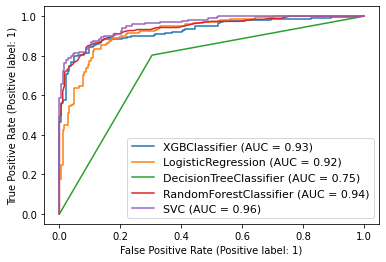

In [122]:
disp = plot_roc_curve(xgbc,x_test,y_test)
plot_roc_curve(lr,x_test,y_test,ax=disp.ax_)
plot_roc_curve(dt,x_test,y_test,ax=disp.ax_)
plot_roc_curve(rf,x_test,y_test,ax=disp.ax_)
plot_roc_curve(svc,x_test,y_test,ax=disp.ax_)
plt.legend(prop={'size':11},loc='lower right')
plt.show()

#### The AUC score is maximum for SVC, but that might be due to overfitting, to get rid of that I am considering XGBoost as the best model because the difference between accuracy score and cross-validation score is less in XGBC

#### Saving the model

In [123]:
filename = 'Insurance_fraud_detection.pkl'
pickle.dump(xgbc,open(filename,'wb'))